In [40]:
from Data_Import import DataImport
from sys import argv
import folium   # (https://pypi.python.org/pypi/folium)
import seaborn as sns
import pandas as pd
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
from sklearn import preprocessing, mixture


from turfpy import measurement
from geojson import Point, Feature

from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.layouts import gridplot, column, grid
from bokeh.models import DatetimeTickFormatter, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Viridis, Cividis, Category10


from pomegranate import *

In [41]:

start_datetime =  '2021-05-13 18:00:00+00:0'
end_datetime = '2021-05-13 18:50:00+00:0' 

DataImporter = DataImport()
df = DataImporter.get_dataframe_from_gpx(fname='rutland_13_05_2021.gpx')

## treat Time
df['time_utc'] = pd.to_datetime(df['time']).dt.strftime('%H:%M:%S')
## add id
df["id"] = df.index
# filters
df = df[ df['time']>start_datetime ]
df = df[ df['time']<end_datetime]
df.head(10)




,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350
1351,52.645664,-0.634849,88.000000,2021-05-13 18:00:06+00:00,100.0,7.998761,18:00:06,1351
1352,52.645664,-0.634849,88.000000,2021-05-13 18:00:07+00:00,98.0,3.621121,18:00:07,1352
1353,52.645694,-0.634830,88.199997,2021-05-13 18:00:08+00:00,97.0,3.575458,18:00:08,1353
1354,52.645723,-0.634809,88.000000,2021-05-13 18:00:09+00:00,99.0,3.512407,18:00:09,1354
1355,52.645752,-0.634788,87.800003,2021-05-13 18:00:10+00:00,98.0,3.524433,18:00:10,1355


### Shift lat. and lnong. cols by 1 to create end data points

In [42]:
df['latitude_plus1'] = df['latitude'].shift(-1)
df['longitude_plus1'] = df['longitude'].shift(-1)

In [43]:

def calculate_initial_compass_bearing(pointA, pointB):
    """
    https://gist.github.com/jeromer/2005586
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def get_bearing(start_lat, start_long, end_lat, end_long):
    start = Feature(geometry=Point((start_lat, start_long)))
    end = Feature(geometry=Point((end_lat, end_long)))
    return measurement.bearing(start, end)

df['bearing'] = df.apply(lambda x: get_bearing(x.latitude, x.longitude, x.latitude_plus1, x.longitude_plus1), axis=1)
df['bearing'].replace(0,None, inplace=True)
df['compass_bearing'] = df.apply(lambda x: calculate_initial_compass_bearing((x.latitude, x.longitude), (x.latitude_plus1, x.longitude_plus1)), axis=1)
df['compass_bearing'].replace(0,None, inplace=True)

df['speed_SMA'] = df.speed.rolling(2, min_periods=1).mean()

print('max sma speed:', df.speed_SMA.max())
print('max speed:', df.speed.max())


max sma speed: 13.875597613639101
max speed: 16.594576583587397


In [44]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):
      k = 6378137
      df["x"] = df['longitude'] * (k * np.pi/180.0)
      df["y"] = np.log(np.tan((90 + df['latitude']) * np.pi/360.0)) * k
      return df

wgs84_to_web_mercator(df)

,latitude,longitude,elevation,time,heart_rate,speed,time_utc,id,latitude_plus1,longitude_plus1,bearing,compass_bearing,speed_SMA,x,y
1346,52.645436,-0.634860,87.000000,2021-05-13 18:00:01+00:00,97.0,4.558620,18:00:01,1346,52.645476,-0.634872,106.700213,349.079548,4.558620,-70672.256221,6.917681e+06
1347,52.645476,-0.634872,87.000000,2021-05-13 18:00:02+00:00,98.0,4.629756,18:00:02,1347,52.645518,-0.634883,104.677256,351.085574,4.594188,-70673.674486,6.917688e+06
1348,52.645518,-0.634883,87.199997,2021-05-13 18:00:03+00:00,99.0,4.607734,18:00:03,1348,52.645558,-0.634885,92.862581,358.407067,4.618745,-70674.878146,6.917696e+06
1349,52.645558,-0.634885,87.599998,2021-05-13 18:00:04+00:00,100.0,4.273853,18:00:04,1349,52.645594,-0.634879,80.537108,6.106820,4.440793,-70675.083421,6.917703e+06
1350,52.645594,-0.634879,87.800003,2021-05-13 18:00:05+00:00,100.0,6.024092,18:00:05,1350,52.645664,-0.634849,66.800136,14.682522,5.148972,-70674.374288,6.917710e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,52.643314,-0.634387,85.400002,2021-05-13 18:49:55+00:00,97.0,3.595186,18:49:55,4262,52.643300,-0.634425,-159.776280,239.991192,4.152270,-70619.659111,6.917291e+06
4263,52.643300,-0.634425,85.199997,2021-05-13 18:49:56+00:00,97.0,2.814301,18:49:56,4263,52.643293,-0.634463,-169.563151,252.662335,3.204744,-70623.839261,6.917289e+06
4264,52.643293,-0.634463,85.199997,2021-05-13 18:49:57+00:00,97.0,2.852372,18:49:57,4264,52.643291,-0.634507,-177.397597,265.023988,2.833337,-70628.075395,6.917287e+06
4265,52.643291,-0.634507,85.199997,2021-05-13 18:49:58+00:00,97.0,2.987993,18:49:58,4265,52.643295,-0.634551,174.805888,278.326286,2.920183,-70633.020662,6.917287e+06


In [45]:
df['angle_from_mean'] = df['bearing'] - df['bearing'].mean()
df['abs_angle_from_mean'] = df['angle_from_mean'].abs()
df['phase'] = np.where(df['angle_from_mean'].abs()<100, 'upwind','downwind')

In [46]:
## normalise
x = df['speed'].values #returns a numpy array
x = x.reshape(-1, 1) # reshape as just have a single feature here
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['speed_norm'] = x_scaled
len(df)

2921

In [47]:

#output_notebook()

x = df['time'].tolist()
y0 = df['x']
y1 = df['y']
y2 = df['speed'].tolist()
y3 = df['speed_norm'].tolist()
y4 = df['bearing'].tolist()
y5 = df['compass_bearing'].tolist()
c0 = df['bearing'].mean()*np.ones(len(y3))
c0 = c0.tolist()
phase = df['phase']



# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1, y2=y2, y3=y3, y4=y4, y5=y5, c0=c0, phase=phase))

pal = Category10[3]
colors = factor_cmap('phase', palette=pal, factors=['upwind','downwind','None']) 

TOOLS = "box_select,lasso_select,help"

tile_provider = get_provider(CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p1 = figure(x_range=(df['x'].min(), df['x'].max()), y_range=(df['y'].min(), df['y'].max()),
           x_axis_type="mercator", y_axis_type="mercator", plot_width=1200, plot_height=600)
p1.add_tile(tile_provider)

p1.circle('y0', 'y1', legend_label="track.", line_width=1, source=source, color=colors)


# speed
p2 = figure(tools=TOOLS, plot_width=600, plot_height=300, title='speed')
p2.circle('x', 'y2', source=source)
p2.xaxis.formatter=DatetimeTickFormatter(
    days=["%m/%d %H:%M:%S"],
    months=["%m/%d %H:%M:%S"],
    hours=["%m/%d %H:%M:%S"],
    minutes=["%m/%d %H:%M:%S"]
)
p2.xaxis.major_label_orientation = pi/4

# speed_norm
p3 = figure(tools=TOOLS, plot_width=600, plot_height=300, title='speed norm')
p3.circle('x', 'y3', source=source)
#p3.line('x' , 'c0', source=source, color='red', width=1.5,line_dash='dashed')
p3.xaxis.formatter=DatetimeTickFormatter(
    days=["%m/%d %H:%M:%S"],
    months=["%m/%d %H:%M:%S"],
    hours=["%m/%d %H:%M:%S"],
    minutes=["%m/%d %H:%M:%S"]
)
p3.xaxis.major_label_orientation = pi/4

p = grid([[p2, p3], [p1]])

show(p)

In [48]:
print(df['bearing'].mean())
print(df['compass_bearing'].mean())

20.720958791712928
134.5940962089346


array([<AxesSubplot:title={'center':'abs_angle_from_mean'}>], dtype=object)

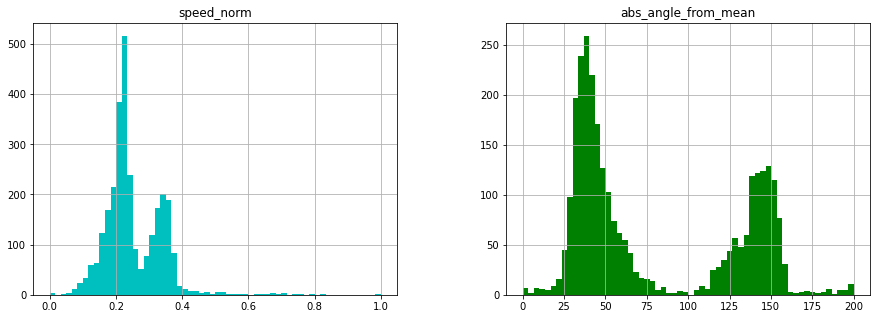

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df.hist(ax=axes[0], column='speed_norm', bins=60, color='c')
df.hist(ax=axes[1], column='abs_angle_from_mean', bins=60, color='g')
#hist = df.hist(column='speed_norm', bins=60, color='c')

In [50]:
speed = df['speed_norm'].to_numpy()
speed_filtered = speed[~np.isnan(speed)]
speed_filtered = speed_filtered.reshape(-1,1)
gmm_speed = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(speed_filtered)
means_speed = gmm_speed.means_
vars_speed = np.sqrt(gmm_speed.covariances_)
print('speed means:', means_speed)
print('speed vars:', vars_speed)

angle = df['abs_angle_from_mean'].to_numpy()
angle_filtered = angle[~np.isnan(angle)]
angle_filtered = angle_filtered.reshape(-1,1)
gmm_angle = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(angle_filtered)
means_angle = gmm_angle.means_
vars_angle = np.sqrt(gmm_angle.covariances_)
print('angle means:', means_angle)
print('angle vars:', vars_angle)
#gmm = GeneralMixtureModel.from_samples(NormalDistribution, 2, data, verbose=True)

speed means: [[0.2765535]
 [0.2120513]]
speed vars: [[[0.10087404]]

 [[0.02289887]]]
angle means: [[ 42.52274204]
 [141.83600475]]
angle vars: [[[12.60130921]]

 [[15.44810591]]]


In [51]:
''' ### Initialise Model ### '''
hmm = HiddenMarkovModel()

''' ### Set Emission Probabilities ### '''
upwind_probs = NormalDistribution(means[1][0], vars[1][0][0])
downwind_probs = NormalDistribution(means[0][0], vars[0][0][0])

upwind  = State(upwind_probs , name='upwind' )
downwind = State(downwind_probs, name='downwind')

hmm.add_states(upwind, downwind)

''' ### Set Transition probabilities ### '''
hmm.add_transition( hmm.start, upwind, 0.5 )
hmm.add_transition( hmm.start, still, 0.5 )
hmm.add_transition( upwind, upwind, 0.9 )
hmm.add_transition( upwind, downwind, 0.1 )
hmm.add_transition( downwind, upwind, 0.1 )
hmm.add_transition( downwind, downwind, 0.9 )

''' ### Bake model ### '''
hmm.bake()


NameError: name 'still' is not defined

In [571]:
hmm_predictions = hmm.predict( data )
print(len(hmm_predictions))
print(len(df))

2921
2921


In [572]:
len(df.id)

2921

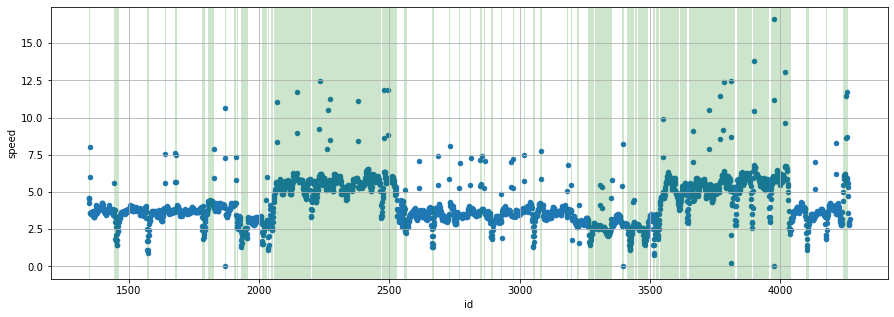

In [573]:
df['phase_prediction'] = hmm_predictions
df
#hp_plt = pd.DataFrame(hmm_predictions).astype('int').reset_index()
#hp_plt.columns = ['time','prediction']
#hp_plt.describe()
ax =  df.plot(x = 'id', y='speed',kind='scatter',figsize=[15,5])

downwind_times = df[df.phase_prediction==1].index
for i in downwind_times:
    ax.axvspan(i,i+1, facecolor='green', edgecolor='none', alpha=.2)
plt.grid()
#plt.xlim([0,len(hmm_predictions)])
# plt.xlabel('time',fontsize=20);
# plt.ylabel('steps',fontsize=20);

In [574]:
df.to_csv('df.csv')

In [575]:
len(df)

2921